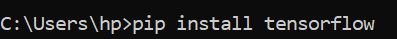

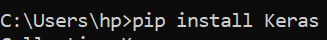

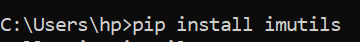

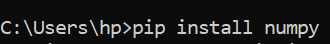

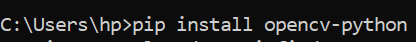

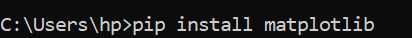

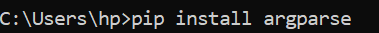

In [1]:
# Step-2 Lets Take a look at the dataset 
# Step-3 Data Preprocessing

In [2]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical

In [3]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import os

In [4]:
pip install imutils

  Using cached imutils-0.5.4.tar.gz (17 kB)
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25860 sha256=3c7ba7371440dff02ef2b591b3497ba3e7870aef16c33eede4849fce1b43aecb
  Stored in directory: c:\users\hp\appdata\local\pip\cache\wheels\86\d7\0a\4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
Successfully built imutils
Note: you may need to restart the kernel to use updated packages.


In [7]:
from imutils import paths

In [8]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [9]:
DIRECTORY = r"C:\Users\hp\Desktop\Data Science\TSF\task Object detection and OCR\facemask\Face-Mask-Detection-master\dataset"
CATEGORIES = ["with_mask", "without_mask"]

In [10]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")

[INFO] loading images...


In [11]:
data = []
labels = []

In [12]:
for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	data.append(image)
    	labels.append(category)

C:\Users\hp\anaconda3\lib\site-packages\PIL\Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [13]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [14]:
data = np.array(data, dtype="float32")
labels = np.array(labels)
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

In [15]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [16]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

In [17]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [18]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [19]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

In [20]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


In [21]:
# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] training head...
Epoch 1/20
95/95 [==============================] - 278s 3s/step - loss: 0.5929 - accuracy: 0.7411 - val_loss: 0.1553 - val_accuracy: 0.9909
Epoch 2/20
95/95 [==============================] - 254s 3s/step - loss: 0.1751 - accuracy: 0.9570 - val_loss: 0.0760 - val_accuracy: 0.9935
Epoch 3/20
95/95 [==============================] - 167s 2s/step - loss: 0.1148 - accuracy: 0.9735 - val_loss: 0.0538 - val_accuracy: 0.9935
Epoch 4/20
95/95 [==============================] - 160s 2s/step - loss: 0.0770 - accuracy: 0.9821 - val_loss: 0.0427 - val_accuracy: 0.9922
Epoch 5/20
95/95 [==============================] - 157s 2s/step - loss: 0.0706 - accuracy: 0.9766 - val_loss: 0.0366 - val_accuracy: 0.9922
Epoch 6/20
95/95 [==============================] - 157s 2s/step - loss: 0.0622 - accuracy: 0.9857 - val_loss: 0.0335 - val_accuracy: 0.9935
Epoch 7/20
95/95 [==============================] - 164s 2s/step - loss: 0.0640 - accuracy: 0.9811 - val_loss: 0.0366 - val_accura

In [22]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

[INFO] evaluating network...


In [23]:
import numpy as np

In [24]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

In [25]:
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       383
without_mask       0.99      0.99      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767



In [26]:
# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")

[INFO] saving mask detector model...


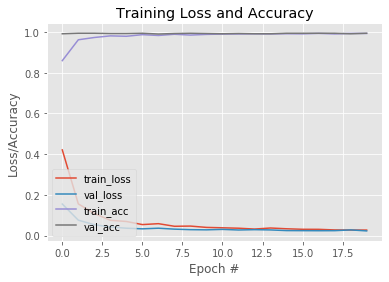

In [27]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")